# Sudoku Solver AI
Using CNNs

## Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from model_utility import sudoku_as_images, shuffle_together

## Constants

In [2]:
DATA_POINTS = 1_000
BATCH_SIZE = 32
RANDOM_STATE = 7
TRAIN_SIZE, VAL_SIZE, TEST_SIZE = 0.85, 0.1, 0.05

## Loading Data

In [3]:
df = pd.read_csv("..\..\Datasets\Sudoku Puzzles\sudoku.csv", nrows = DATA_POINTS)
df.head()

,puzzle,solution
0,0700000430400096108006349000940520003584600200...,6795182435437296188216349577943521863584617292...
1,3010865040465210705000000014008000020803479000...,3719865248465213795924738614638197522853479167...
2,0483015603600080909106700030200009355090102006...,7483915623652487919126754834217869355894132766...
3,0083170000042051090000400703271609049014500000...,2983176457642851391539462783271689549814537266...
4,0408906300001368208007405190004670524500207002...,1428956379751368248367425193984671524513287962...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   puzzle    1000 non-null   object
 1   solution  1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB


## Data preprocessing

### Refactoring data to 9 X 9 numpy arrays

In [5]:
puzzles = np.array(list(map(list, df['puzzle'].values))).reshape(-1, 9, 9).astype(int)
puzzles[0]

array([[0, 7, 0, 0, 0, 0, 0, 4, 3],
       [0, 4, 0, 0, 0, 9, 6, 1, 0],
       [8, 0, 0, 6, 3, 4, 9, 0, 0],
       [0, 9, 4, 0, 5, 2, 0, 0, 0],
       [3, 5, 8, 4, 6, 0, 0, 2, 0],
       [0, 0, 0, 8, 0, 0, 5, 3, 0],
       [0, 8, 0, 0, 7, 0, 0, 9, 1],
       [9, 0, 2, 1, 0, 0, 0, 0, 5],
       [0, 0, 7, 0, 4, 0, 8, 0, 2]])

In [6]:
solutions = np.array(list(map(list, df['solution'].values))).reshape(-1, 9, 9).astype(int)
solutions[0]

array([[6, 7, 9, 5, 1, 8, 2, 4, 3],
       [5, 4, 3, 7, 2, 9, 6, 1, 8],
       [8, 2, 1, 6, 3, 4, 9, 5, 7],
       [7, 9, 4, 3, 5, 2, 1, 8, 6],
       [3, 5, 8, 4, 6, 1, 7, 2, 9],
       [2, 1, 6, 8, 9, 7, 5, 3, 4],
       [4, 8, 5, 2, 7, 6, 3, 9, 1],
       [9, 6, 2, 1, 8, 3, 4, 7, 5],
       [1, 3, 7, 9, 4, 5, 8, 6, 2]])

### Normalising the data

In [7]:
puzzles = puzzles/9
puzzles[0]

array([[0.        , 0.77777778, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.44444444, 0.33333333],
       [0.        , 0.44444444, 0.        , 0.        , 0.        ,
        1.        , 0.66666667, 0.11111111, 0.        ],
       [0.88888889, 0.        , 0.        , 0.66666667, 0.33333333,
        0.44444444, 1.        , 0.        , 0.        ],
       [0.        , 1.        , 0.44444444, 0.        , 0.55555556,
        0.22222222, 0.        , 0.        , 0.        ],
       [0.33333333, 0.55555556, 0.88888889, 0.44444444, 0.66666667,
        0.        , 0.        , 0.22222222, 0.        ],
       [0.        , 0.        , 0.        , 0.88888889, 0.        ,
        0.        , 0.55555556, 0.33333333, 0.        ],
       [0.        , 0.88888889, 0.        , 0.        , 0.77777778,
        0.        , 0.        , 1.        , 0.11111111],
       [1.        , 0.        , 0.22222222, 0.11111111, 0.        ,
        0.        , 0.        , 0.        , 0.55555556],


In [8]:
solutions = solutions/9
solutions[0]

array([[0.66666667, 0.77777778, 1.        , 0.55555556, 0.11111111,
        0.88888889, 0.22222222, 0.44444444, 0.33333333],
       [0.55555556, 0.44444444, 0.33333333, 0.77777778, 0.22222222,
        1.        , 0.66666667, 0.11111111, 0.88888889],
       [0.88888889, 0.22222222, 0.11111111, 0.66666667, 0.33333333,
        0.44444444, 1.        , 0.55555556, 0.77777778],
       [0.77777778, 1.        , 0.44444444, 0.33333333, 0.55555556,
        0.22222222, 0.11111111, 0.88888889, 0.66666667],
       [0.33333333, 0.55555556, 0.88888889, 0.44444444, 0.66666667,
        0.11111111, 0.77777778, 0.22222222, 1.        ],
       [0.22222222, 0.11111111, 0.66666667, 0.88888889, 1.        ,
        0.77777778, 0.55555556, 0.33333333, 0.44444444],
       [0.44444444, 0.88888889, 0.55555556, 0.22222222, 0.77777778,
        0.66666667, 0.33333333, 1.        , 0.11111111],
       [1.        , 0.66666667, 0.22222222, 0.11111111, 0.88888889,
        0.33333333, 0.44444444, 0.77777778, 0.55555556],


## Cleanup
Deleting variables no more required to clear memory

In [9]:
del df

## Data Visualization

Since the data is in square arrays with values between 0 and 1, they can be easily visualised as images.

The pure black sections in the images of the puzzles denote the cells which need to be filled.

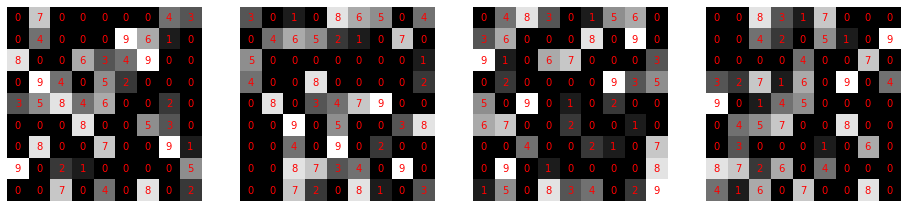

In [10]:
sudoku_as_images(puzzles[:4], annot_color = 'red')

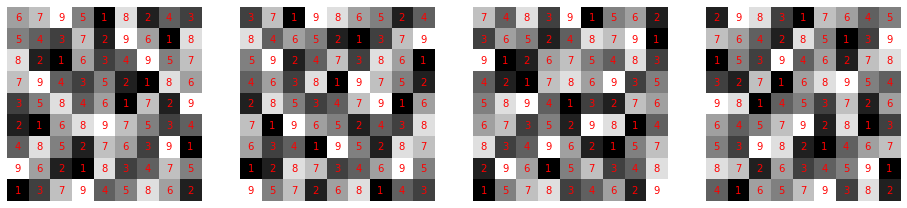

In [11]:
sudoku_as_images(solutions[:4], annot_color = 'red')

## Train, Validation and Test data preparation

### Shuffle the inputs and outputs in place

In [12]:
shuffle_together([puzzles, solutions], RANDOM_STATE)

### Training Data

In [13]:
X_train = puzzles[: int(DATA_POINTS * TRAIN_SIZE)]
y_train = solutions[: int(DATA_POINTS * TRAIN_SIZE)]

print("Training data:")
print(f"Input shape - {X_train.shape}")
print(f"Output shape - {y_train.shape}")

Training data:
Input shape - (850, 9, 9)
Output shape - (850, 9, 9)


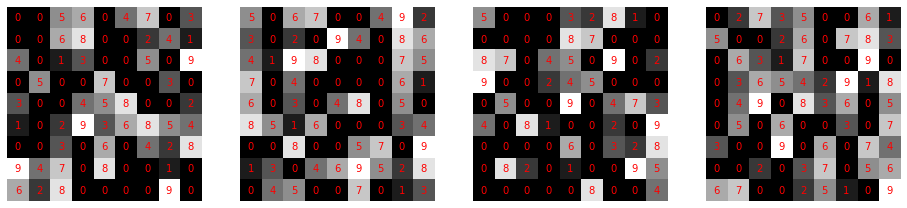

In [14]:
sudoku_as_images(X_train[:4])

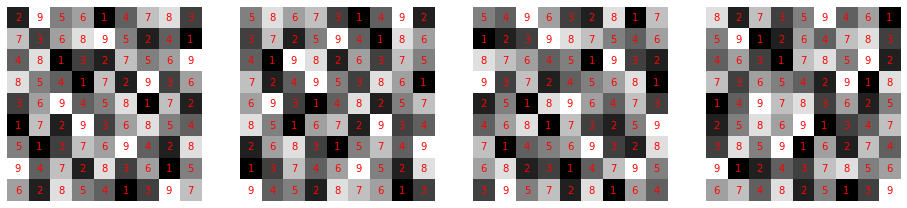

In [15]:
sudoku_as_images(y_train[:4])

### Validation Data

In [16]:
val_data_range = range(int(DATA_POINTS * TRAIN_SIZE), int(DATA_POINTS * (TRAIN_SIZE + VAL_SIZE)))

X_val = puzzles[val_data_range]
y_val = solutions[val_data_range]

print("Validation data:")
print(f"Input shape - {X_val.shape}")
print(f"Output shape - {y_val.shape}")

Validation data:
Input shape - (100, 9, 9)
Output shape - (100, 9, 9)


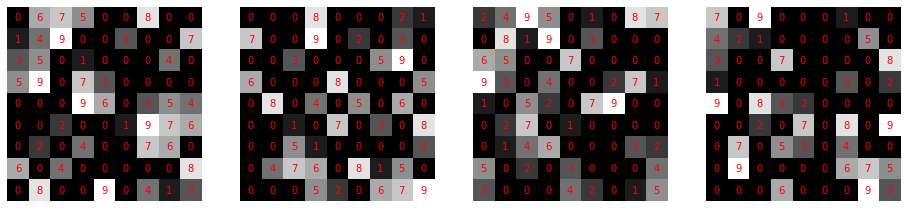

In [17]:
sudoku_as_images(X_val[:4])

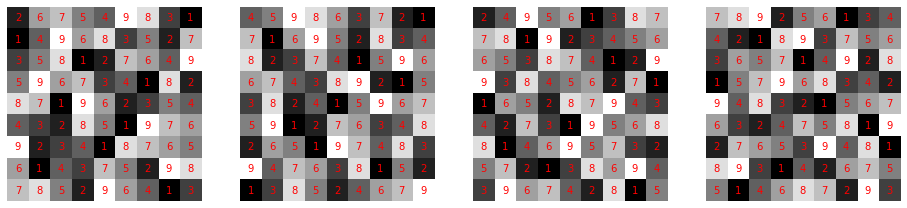

In [18]:
sudoku_as_images(y_val[:4])

### Testing Data

In [19]:
X_test = puzzles[int(DATA_POINTS * (TRAIN_SIZE + VAL_SIZE)):]
y_test = solutions[int(DATA_POINTS * (TRAIN_SIZE + VAL_SIZE)):]

print("Training data:")
print(f"Input shape - {X_test.shape}")
print(f"Output shape - {y_test.shape}")

Training data:
Input shape - (50, 9, 9)
Output shape - (50, 9, 9)


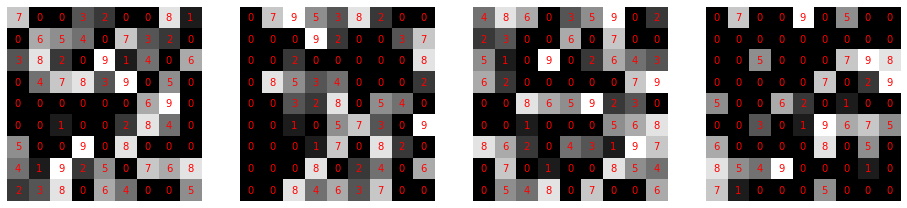

In [20]:
sudoku_as_images(X_test[:4])

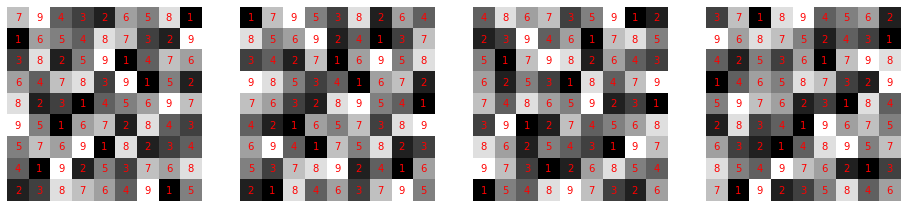

In [21]:
sudoku_as_images(y_test[:4])